<img src="assets/ucu-bg.jpg" alt="UCU Machine Learning Workshops 2017" style="height: 400px; border: 2px solid #C08050">

# Practice: Day 4

## Paraphrase Identification on Quora Question Dataset

You are given a dataset that contains 400k pairs of question titles from Quora. For each question pair, a supervised label is given by a human annotator: whether both questions in the pair are considered to have the same intent (`is_duplicate = 1`) or not (`is_duplicate = 0`).

Note that the human judgment about a particular pair being a duplicate can be subjective, so expect some "noise" in the target values.

Your task is to build a model that, given two question titles, predicts whether they have the same intent. Some infrastructural parts are created for your convenience. Fill out the rest as you go along.

**Example Plan**

1. You should start with a baseline model, which could be cosine similarity over BoW vectors. Optionally, you can try using TF-IDF afterwards and compare the results to simple counting.
2. Then, try leveraging some pre-trained word embeddings (e.g. fastText on Wikipedia, or Word2Vec on Google News etc.) and calculating the Word Mover's Distance as a feature. You can also use this feature later in step 4.
3. Then, encode the questions as fixed-length padded sequences of word embeddings, and create a neural network (e.g. with a Multi-Layer Perceptron architecture). You might want to allocate a separate validation set for picking the hyperparameters.
4. (Advanced) Use BoW cosine similarity, TF-IDF cosine similarity, WMD, and the predictions of the neural network as features for a 2nd-level model.

**Helpful Modules and Functions**

For baseline models:

* `gensim.models.wrappers.fasttext.FastText.wmdistance`
* `sklearn.feature_extraction.text.CountVectorizer` and `sklearn.feature_extraction.text.TfIdfVectorizer`

For neural models:

* `keras.preprocessing.text.Tokenizer`
* `keras.preprocessing.sequence.pad_sequences`
* `keras.models.Sequential`

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import log_loss, precision_score, recall_score, f1_score

In [3]:
%matplotlib inline

## Configuration

Make the subsequent runs reproducible.

In [4]:
RANDOM_STATE = 42

In [5]:
np.random.seed(RANDOM_STATE)

## Read Data

In [6]:
df_orig = pd.read_csv('practical4/quora-train.csv')

In [7]:
df_orig.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


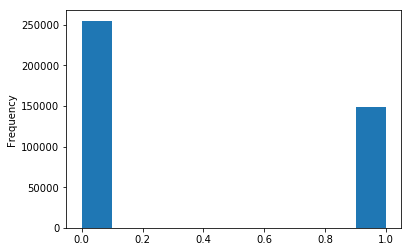

In [8]:
df_orig.is_duplicate.plot.hist()

## Partition Data

Remember the indices for the training and test sets.

In [9]:

splitter = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

In [10]:
ix_train, ix_test = next(splitter.split(df_orig, df_orig.is_duplicate))

In [11]:
print('Training set length:', ix_train.shape)
print('Test set length:    ', ix_test.shape)

('Training set length:', (323432,))
('Test set length:    ', (80858,))


In [12]:
X = np.zeros((len(df_orig), 1))
y = df_orig.is_duplicate.values

## Begin Modeling

Split the data.

In [13]:
X_train = X[ix_train]
y_train = y[ix_train]

X_test = X[ix_test]
y_test = y[ix_test]

In [14]:
print('X train:', X_train.shape)
print('y train:', y_train.shape)
print('X test: ', X_test.shape)
print('y test: ', y_test.shape)
print(ix_train)


('X train:', (323432, 1))
('y train:', (323432,))
('X test: ', (80858, 1))
('y test: ', (80858,))
[341317 237560 280719 ..., 311479 250945 254739]


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


df_orig.question2.replace(np.nan, 'nan', inplace=True)
all_q = list(df_orig.question1) + list(df_orig.question2)
tf_vectorizer = CountVectorizer()
tf = tf_vectorizer.fit_transform(all_q)
print("tf",tf.shape)

tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(all_q)
print("tfidf", tfidf.shape)



('tf', (808580, 86152))
('tfidf', (808580, 86152))


In [67]:
import scipy.spatial.distance
# gensim modules
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

# numpy
import numpy

# random
from random import shuffle

# classifier
from sklearn.linear_model import LogisticRegression

def evaluate(y_true, y_pred, threshold=0.5):
    y_pred_label = y_pred >= threshold
    
    print('Log loss: ', log_loss(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred_label))
    print('Recall:   ', recall_score(y_true, y_pred_label))
    print('F1 score: ', f1_score(y_true, y_pred_label))

def build_score(tf):
    offset_pos = tf.shape[0]/2
    train_arrays = []
    train_labels = []
    test_arrays = []
    test_labels = []

    for i in range(offset_pos-1):
        if df_orig.id[i] in ix_train :
            train_arrays.append(scipy.spatial.distance.cosine(tf[i].toarray()[0], tf[offset_pos + i].toarray()[0]))
            train_labels.append(df_orig.is_duplicate[i])
        else:
            test_arrays.append(scipy.spatial.distance.cosine(tf[i].toarray()[0], tf[offset_pos + i].toarray()[0]))
            test_labels.append(df_orig.is_duplicate[i])
    train_arrays = np.nan_to_num(train_arrays)
    train_arrays[np.isneginf(train_arrays)] = 1
    train_arrays[np.isinf(train_arrays)] = 1
    test_arrays = np.nan_to_num(test_arrays)
    test_arrays[np.isneginf(test_arrays)] = 1
    test_arrays[np.isinf(test_arrays)] = 1
    classifier = LogisticRegression()
    classifier.fit(train_arrays.reshape(-1,1), train_labels)
    print(classifier.score(test_arrays.reshape(-1,1), test_labels))
    y_pred_test = classifier.predict(test_arrays.reshape(-1,1))
    evaluate(test_labels, y_pred_test)



In [70]:
build_score(tf)

('Log loss: ', 12.247870740621503)
('Precision:', 0.52785383816447928)
('Recall:   ', 0.37453522259069438)
('F1 score: ', 0.43816988341334373)


In [68]:
build_score(tfidf)

('Log loss: ', 11.842507473929638)
('Precision:', 0.54584212566211621)
('Recall:   ', 0.42458044417646468)
('F1 score: ', 0.4776350001884162)


In [20]:
offset_pos = tf.shape[0]/2
train_arrays = []
train_labels = []
test_arrays = []
test_labels = []

for i in range(offset_pos):
    if df_orig.id[i] in ix_train :
        train_arrays.append(scipy.spatial.distance.cosine(tf[i].toarray()[0], tf[offset_pos + i].toarray()[0]))
        train_labels.append(df_orig.is_duplicate[i])
    else:
        test_arrays.append(scipy.spatial.distance.cosine(tf[i].toarray()[0], tf[offset_pos + i].toarray()[0]))
        test_labels.append(df_orig.is_duplicate[i])

/Users/maxgirilishen/anaconda/lib/python2.7/site-packages/scipy/spatial/distance.py:505: RuntimeWarning: invalid value encountered in true_divide
  dist = 1.0 - np.dot(u, v) / (norm(u) * norm(v))


In [60]:

import math
classifier = LogisticRegression()

train_arrays = np.nan_to_num(train_arrays)
train_labels = np.nan_to_num(train_labels)
test_arrays = np.nan_to_num(test_arrays)
test_labels = np.nan_to_num(test_labels)

classifier.fit(train_arrays.reshape(-1,1), train_labels)
classifier.score(test_arrays.reshape(-1,1), test_labels)
y_pred_test = classifier.predict(test_arrays.reshape(-1,1))


**<span style="color: red">TODO:</span> Train your model.**

**<span style="color: red">TODO:</span> Make predictions from your model.**

In [ ]:
#y_pred_train = np.random.uniform(size=y_train.shape)
#y_pred_test = np.random.uniform(size=y_test.shape)

## Evaluate

In [62]:
def evaluate(y_true, y_pred, threshold=0.5):
    y_pred_label = y_pred >= threshold
    
    print('Log loss: ', log_loss(y_true, y_pred))
    print('Precision:', precision_score(y_true, y_pred_label))
    print('Recall:   ', recall_score(y_true, y_pred_label))
    print('F1 score: ', f1_score(y_true, y_pred_label))

**Training evaluation**

In [ ]:
evaluate(y_train, y_pred_train)

**Test evaluation**

In [69]:
evaluate(test_labels, y_pred_test)

('Log loss: ', 12.248297903994235)
('Precision:', 0.52782891941651322)
('Recall:   ', 0.37453522259069438)
('F1 score: ', 0.43816129790735947)
